In [1]:
import torch
import torch.optim as optim
from models.attention import Attention
from matplotlib import pyplot as plt
from utils.helper import make_beta_schedule, EMA, ObjectView
from utils.plots import hdr_plot_style
hdr_plot_style()
from tqdm import tqdm
from ddpm import DDPM1d
import datetime

In [2]:
device = torch.device("cuda:1") if torch.cuda.is_available() else "cpu"

In [3]:
config_pecan = {
    'n_steps': 500,
    'input_dim': 96,
    'hidden_dim': 800,
    'nhead': 4,
    'cond_dim': 213,
    'epoch': 16000,
    'batch_size': 5000,
    'learning_rate': 5e-4,
    'lr_decay': 0.9,
    'lr_decay_step':1000,
    'ema_decay': 0.9,
    'beta_start': 1e-6,
    'beta_end': 2e-2,
    'loss_type': 'l2',
    'num_class': 5
}
args = ObjectView(config_pecan)

# Dataset

In [4]:
loads = torch.load("./data/Pecan Street Smart Meter Data/loads.pt")
profile = torch.load("./data/Pecan Street Smart Meter Data/profile.pt")
PV_base = torch.load("./data/Pecan Street Smart Meter Data/PV_base.pt")
# Sampling
loads = loads[:args.num_class]
profile = profile[:args.num_class]
PV_base = torch.repeat_interleave(PV_base, repeats=args.num_class, dim=1)
PV_base = PV_base.permute(1, 0, 2)
dataset = torch.empty_like(loads)
for i in range(loads.shape[0]):
    load = loads[i]
    min_val = load.max()
    max_val = load.min()
    dataset[i] = 2 * (load - min_val) / (max_val - min_val) -1

dataset = dataset.reshape(-1, dataset.shape[-1])
cond = profile.reshape(-1, profile.shape[-1])
dataset.shape, dataset.mean(), dataset.var(), dataset.min(), dataset.max()

(torch.Size([140, 96]),
 tensor(0.2409),
 tensor(0.1193),
 tensor(-1.),
 tensor(1.))

In [5]:
dataset.shape, cond.shape, PV_base.shape

(torch.Size([140, 96]), torch.Size([140, 213]), torch.Size([140, 3, 96]))

In [6]:
# Select betas
n_steps = args.n_steps

betas = make_beta_schedule(schedule='linear', n_timesteps=n_steps, start=args.beta_start, end=args.beta_end)
betas = betas.to(device)
model = Attention(args)
model = model.to(device)
dataset = dataset.to(device)
cond = cond.to(device)
PV_base = PV_base.to(device)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.lr_decay_step, gamma=args.lr_decay)
ddpm = DDPM1d(model, betas, n_steps, (args.input_dim,), loss_type='l2')
# Create EMA model
ema = EMA(args.ema_decay)
ema.register(model)

Loss = []
for j in tqdm(range(args.epoch)):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], args.batch_size):
        # Retrieve current batch 
        indices = permutation[i:i+args.batch_size]
        batch_x = dataset[indices]
        batch_cond = cond[indices]
        batch_PV_base = PV_base[indices]
        # Compute the loss.
        loss = ddpm(batch_x, batch_cond, batch_PV_base)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        scheduler.step()
        # Update the exponential moving average
        ema.update(model)
        ddpm.model = model
    if (j+1) % 50 == 0:
        Loss.append(loss.item())
    if (j+1) % 500 == 0:
        print("loss: ", loss.item())
        

/home/npg5/anaconda3/envs/hnn/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  0%|          | 0/16000 [00:00<?, ?it/s]/home/npg5/anaconda3/envs/hnn/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  3%|▎         | 513/16000 [00:07<03:52, 66.62it/s]

loss:  0.14102385938167572


  6%|▋         | 1010/16000 [00:14<03:45, 66.48it/s]

loss:  0.13630741834640503


  9%|▉         | 1507/16000 [00:22<03:38, 66.42it/s]

loss:  0.1187995970249176


 13%|█▎        | 2011/16000 [00:29<03:32, 65.71it/s]

loss:  0.08453397452831268


 16%|█▌        | 2508/16000 [00:37<03:24, 65.99it/s]

loss:  0.09313732385635376


 19%|█▉        | 3012/16000 [00:45<03:16, 66.03it/s]

loss:  0.09865062683820724


 22%|██▏       | 3509/16000 [00:52<03:08, 66.22it/s]

loss:  0.09661605954170227


 25%|██▌       | 4006/16000 [01:00<03:03, 65.40it/s]

loss:  0.0728340893983841


 28%|██▊       | 4510/16000 [01:07<02:50, 67.23it/s]

loss:  0.059922222048044205


 31%|███▏      | 5007/16000 [01:15<02:43, 67.17it/s]

loss:  0.07622534036636353


 34%|███▍      | 5511/16000 [01:22<02:36, 67.15it/s]

loss:  0.0800948217511177


 38%|███▊      | 6008/16000 [01:30<02:28, 67.23it/s]

loss:  0.0775318592786789


 41%|████      | 6512/16000 [01:37<02:20, 67.39it/s]

loss:  0.07469109445810318


 44%|████▍     | 7009/16000 [01:44<02:13, 67.38it/s]

loss:  0.05525532737374306


 47%|████▋     | 7513/16000 [01:52<02:05, 67.44it/s]

loss:  0.06426219642162323


 50%|█████     | 8010/16000 [01:59<01:58, 67.43it/s]

loss:  0.07491007447242737


 53%|█████▎    | 8507/16000 [02:07<01:53, 66.13it/s]

loss:  0.06731318682432175


 56%|█████▋    | 9011/16000 [02:14<01:45, 65.96it/s]

loss:  0.04704708978533745


 59%|█████▉    | 9508/16000 [02:22<01:36, 67.46it/s]

loss:  0.07235785573720932


 63%|██████▎   | 10012/16000 [02:29<01:29, 67.21it/s]

loss:  0.06205771863460541


 66%|██████▌   | 10509/16000 [02:37<01:21, 67.23it/s]

loss:  0.06223119795322418


 69%|██████▉   | 11013/16000 [02:44<01:15, 66.42it/s]

loss:  0.06323745846748352


 72%|███████▏  | 11510/16000 [02:52<01:07, 66.45it/s]

loss:  0.04050539433956146


 75%|███████▌  | 12007/16000 [02:59<01:00, 66.43it/s]

loss:  0.03507010638713837


 78%|███████▊  | 12511/16000 [03:07<00:52, 66.39it/s]

loss:  0.06378453969955444


 81%|████████▏ | 13008/16000 [03:14<00:45, 66.46it/s]

loss:  0.0339311808347702


 84%|████████▍ | 13512/16000 [03:22<00:37, 66.41it/s]

loss:  0.043062228709459305


 88%|████████▊ | 14009/16000 [03:29<00:29, 66.38it/s]

loss:  0.0370318666100502


 91%|█████████ | 14513/16000 [03:37<00:22, 66.38it/s]

loss:  0.057237353175878525


 94%|█████████▍| 15010/16000 [03:44<00:14, 66.36it/s]

loss:  0.04036278650164604


 97%|█████████▋| 15507/16000 [03:52<00:07, 66.42it/s]

loss:  0.033492110669612885


100%|██████████| 16000/16000 [03:59<00:00, 66.76it/s]

loss:  0.04021218791604042


In [7]:
checkpoint = {
    'config': config_pecan,
    'dataset': dataset,
    'cond': cond,
    'ddpm': ddpm,
    'Loss': Loss
}
torch.save(checkpoint, "./result/models/model_pecan_{}.pth".format(datetime.datetime.now().strftime("%m%d-%H%M")))

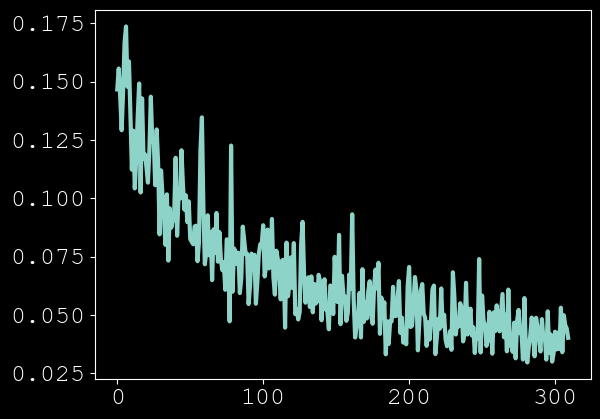

In [8]:
plt.plot(Loss[10:])

In [9]:
def plot_compare(test_id):
    cond_s = cond[test_id*28:(test_id+1)*28]
    cond_PV_base = PV_base[test_id*28:(test_id+1)*28]
    x_seq = ddpm.sample_seq(batch_size=28, cond=cond_s, PV_base = cond_PV_base)

    x_seq = x_seq.to("cpu")

    test_data = dataset[test_id*28:(test_id+1)*28].to('cpu')
    plt.figure(figsize=(15,3), dpi=300)
    plt.subplot(1,4,1)
    for i in range(len(test_data)):
        plt.plot(test_data[i])
    plt.title("actual data")
    plt.subplot(1,4,2)
    for i in range(len(x_seq[-1])):
        plt.plot(x_seq[-1][i])
    plt.title("generated data")
    plt.subplot(1,4,3)
    plt.plot(x_seq[-1].mean(dim=0), label = "mean of generated data")
    plt.plot(test_data.mean(dim=0), label = "mean of actual data")
    plt.legend(fontsize=10)
    plt.subplot(1,4,4)
    plt.plot(x_seq[-1].var(dim=0), label = "variance of generated data")
    plt.plot(test_data.var(dim=0), label = "variance of actual data")
    plt.legend(fontsize=10)
    plt.tight_layout()

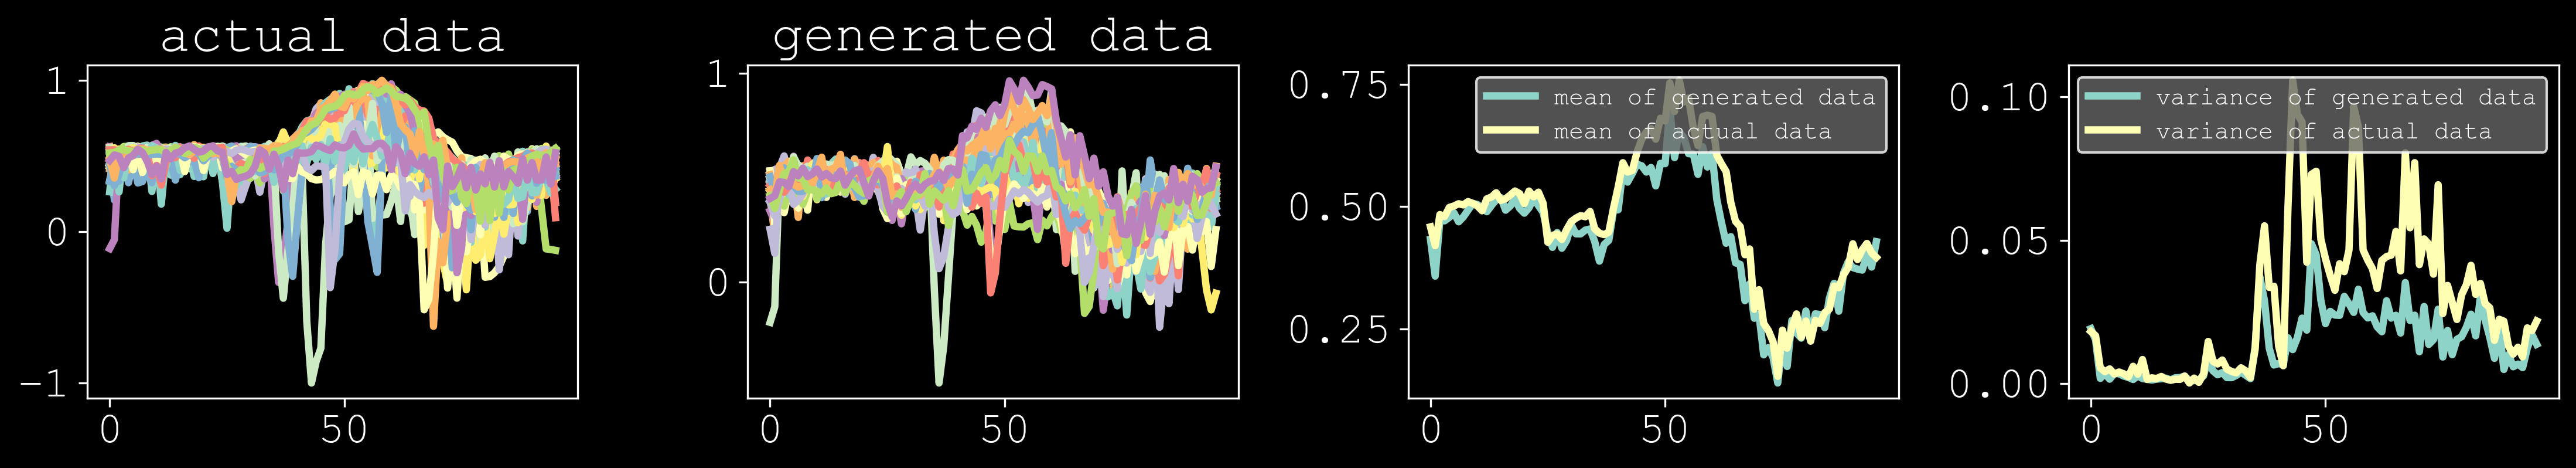

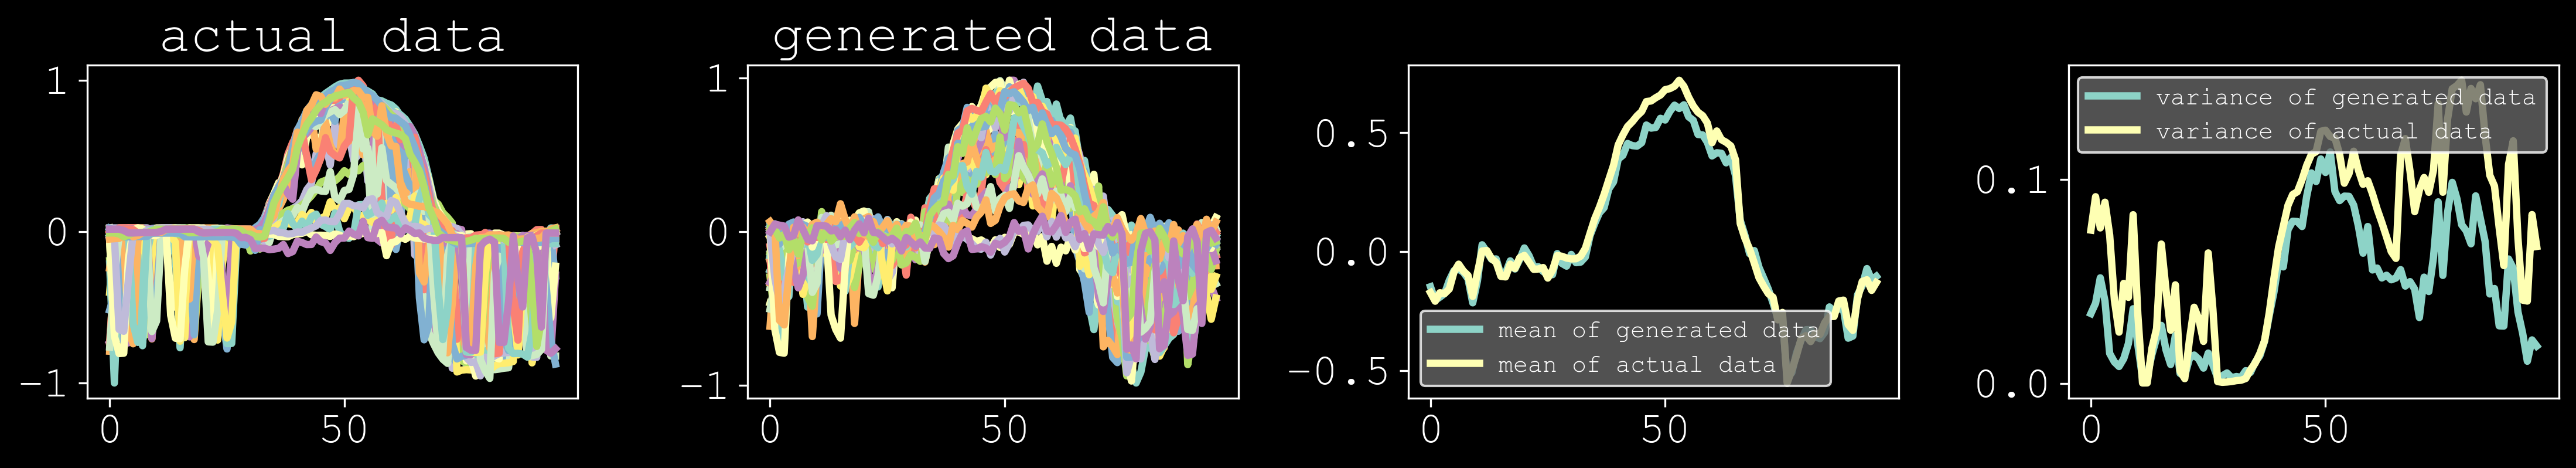

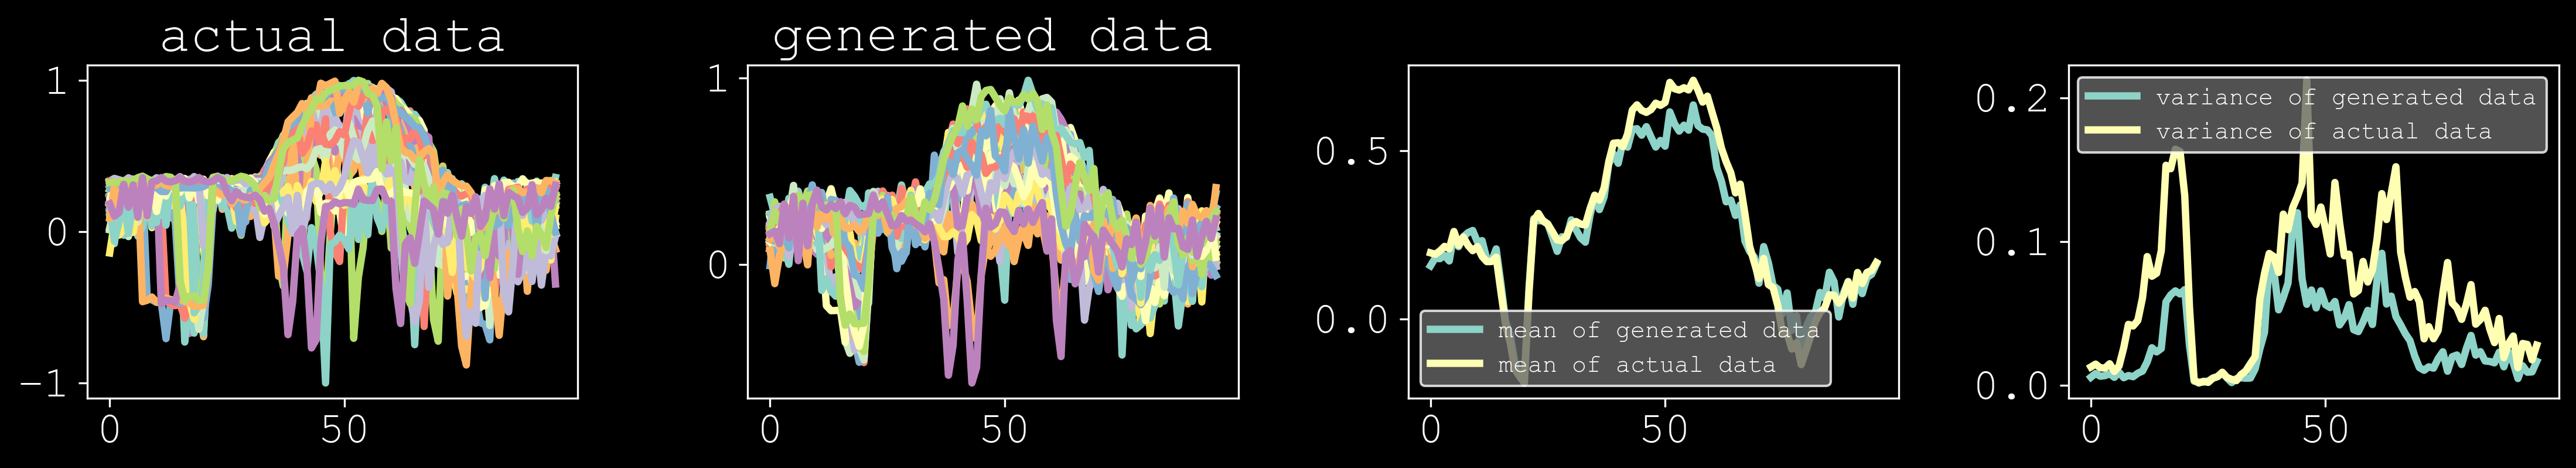

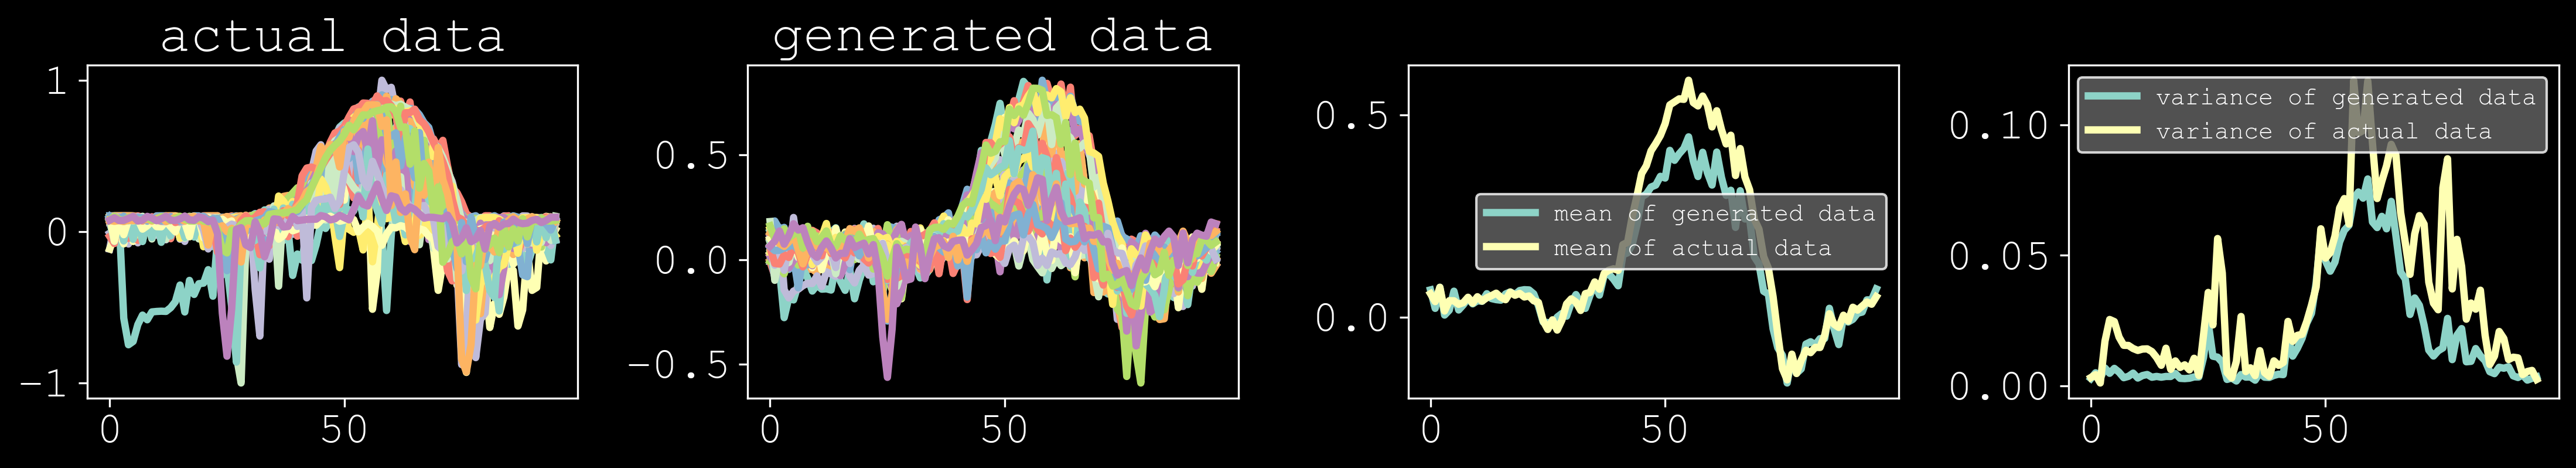

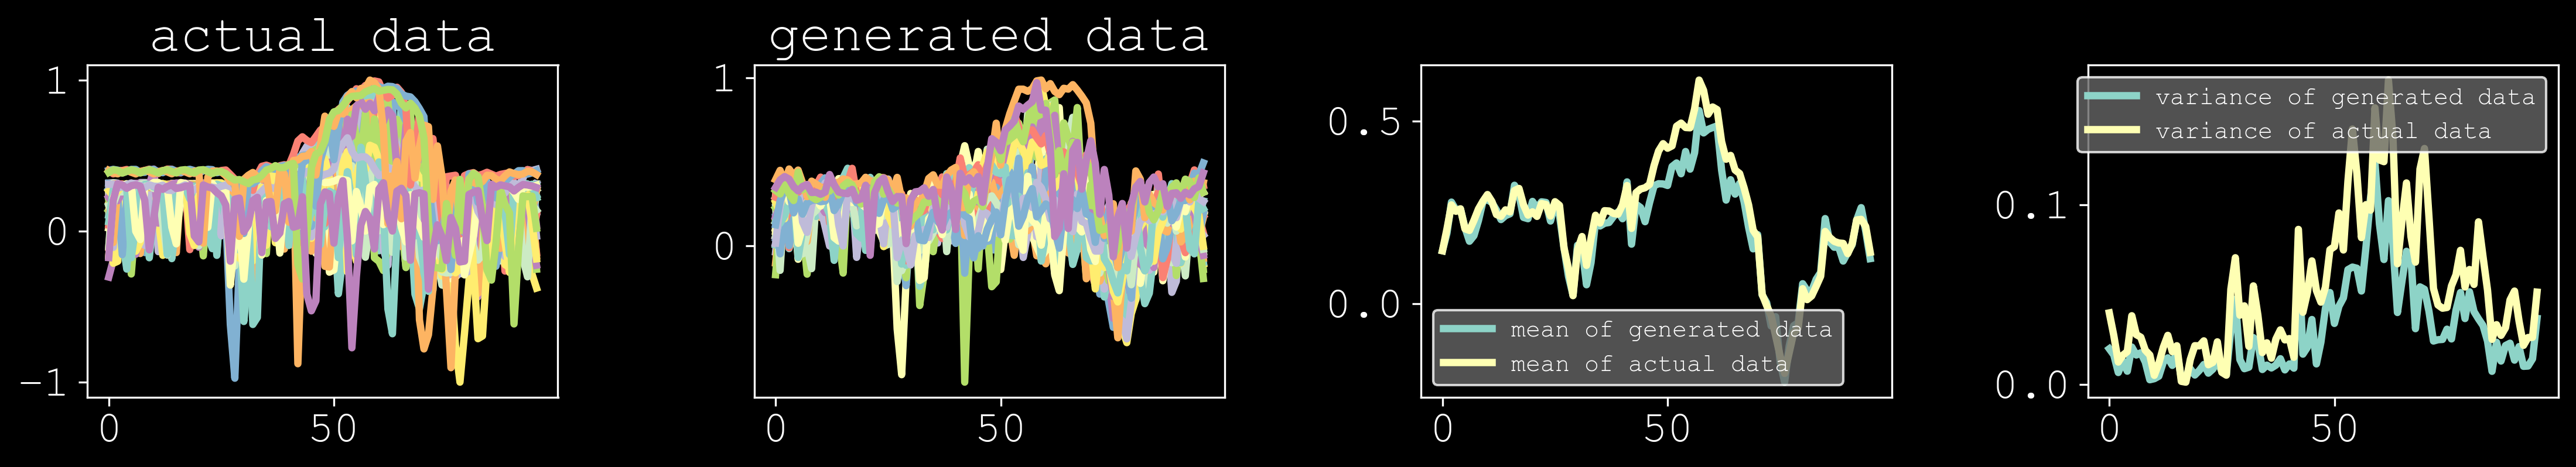

In [10]:
for i in range(5):
    plot_compare(i)


In [11]:
real_gen = torch.load("./data/Pecan Street Smart Meter Data/gens.pt")

In [12]:
# plot deterministic component
def plot_determ_comp(test_id):
    cond_s = cond[test_id*28:(test_id+1)*28]
    PV_base_s = PV_base[test_id*28:(test_id+1)*28]
    x_seq = ddpm.sample_seq(batch_size=28, cond=cond_s, PV_base=PV_base_s, stable=True)
    x_seq = x_seq.to("cpu")

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    for i in range(len(x_seq[-1])):
        plt.plot(-x_seq[-1][i])
    plt.xlabel('time [30 min]')
    plt.title("Estimated solar gen")
    plt.subplot(1,2,2)
    for i in range(len(x_seq[-1])):
        plt.plot(real_gen[0][i])
    plt.xlabel('time [30 min]')
    plt.title("Actual solar gen")
    plt.tight_layout()

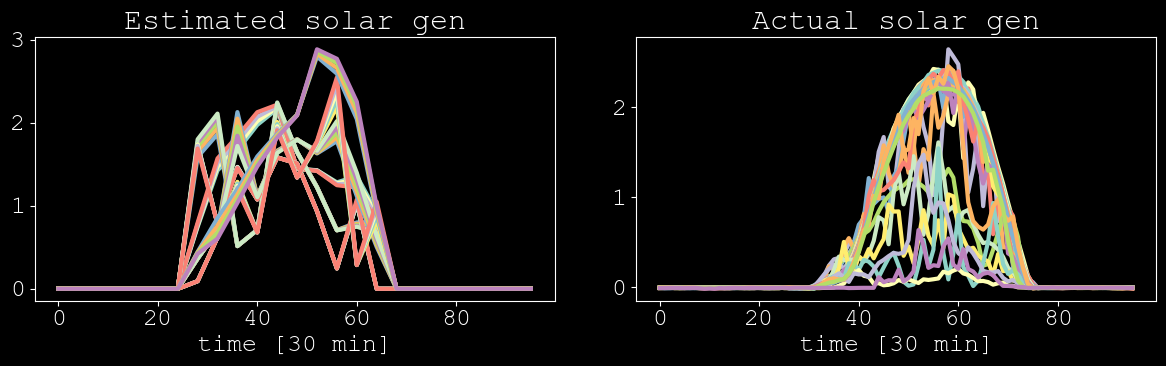

In [13]:
plot_determ_comp(2)